#import basic packages

In [2]:
import functools
import sys
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import tqdm
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

#Load CIFAR-10 Dataset


In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


100%|██████████| 170498071/170498071 [00:04<00:00, 34600801.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入图像尺寸是 3x32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 下采样至 4x4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 输出一个单一的数值
        )

    def forward(self, input):
        return self.main(input).view(-1)



start training Loop.....


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[0/25][0/782]	Loss_D: 1.4523	Loss_G: 1.4463	D(x): 0.4633	D(G(z)): 0.4750 / 0.2411
[0/25][50/782]	Loss_D: 0.2495	Loss_G: 6.1117	D(x): 0.9061	D(G(z)): 0.1349 / 0.0023
[0/25][100/782]	Loss_D: 0.0816	Loss_G: 5.5138	D(x): 0.9538	D(G(z)): 0.0324 / 0.0041
[0/25][150/782]	Loss_D: 0.2558	Loss_G: 3.4753	D(x): 0.8314	D(G(z)): 0.0125 / 0.0498
[0/25][200/782]	Loss_D: 0.3924	Loss_G: 3.4793	D(x): 0.8470	D(G(z)): 0.1794 / 0.0338
[0/25][250/782]	Loss_D: 0.3234	Loss_G: 4.3152	D(x): 0.7839	D(G(z)): 0.0486 / 0.0155
[0/25][300/782]	Loss_D: 0.7608	Loss_G: 3.0828	D(x): 0.6563	D(G(z)): 0.1844 / 0.0614
[0/25][350/782]	Loss_D: 0.9052	Loss_G: 2.6183	D(x): 0.6792	D(G(z)): 0.3511 / 0.0986
[0/25][400/782]	Loss_D: 0.9430	Loss_G: 2.3639	D(x): 0.7094	D(G(z)): 0.3896 / 0.1141
[0/25][450/782]	Loss_D: 0.8432	Loss_G: 2.2119	D(x): 0.6954	D(G(z)): 0.3363 / 0.1217
[0/25][500/782]	Loss_D: 0.9703	Loss_G: 2.2570	D(x): 0.6520	D(G(z)): 0.3463 / 0.1667
[0/25][550/782]	Loss_D: 1.0482	Loss_G: 3.3100	D(x): 0.7185	D(G(z)): 0.4454 / 0.

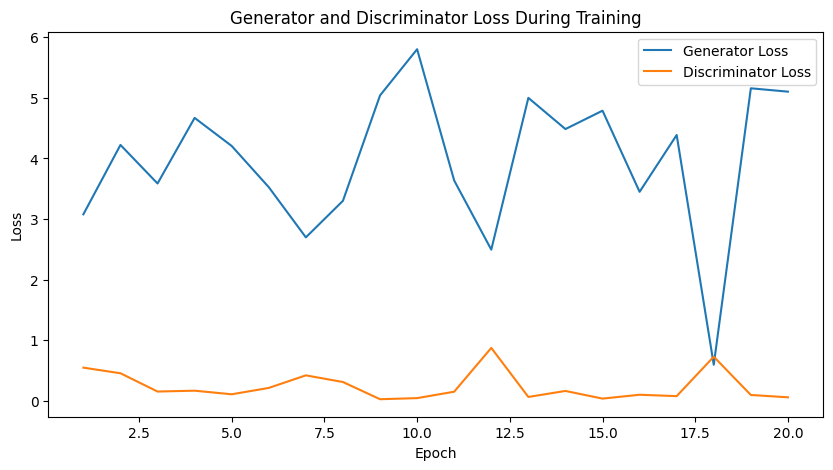

In [6]:
# train the GAN

netG = Generator()
netD = Discriminator()

criterion = nn.BCELoss()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimize_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimize_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

netD.to(device)
netG.to(device)

img_list = []

G_losses = []
D_losses = []


print('start training Loop.....')
for epoch in range(20):
    for i, data in enumerate(trainloader, 0):

        netD.zero_grad()
        # train with real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimize_D.step()

        # train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimize_G.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, 25, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #plot the Epoch loss
    G_losses.append(errG.item())
    D_losses.append(errD.item())

def plot_losses(G_losses, D_losses):
    epochs = range(1, len(G_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(epochs, G_losses, label="Generator Loss")
    plt.plot(epochs, D_losses, label="Discriminator Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(G_losses, D_losses)









Gradient of netG.main.0.weight: 53.9268684387207
Gradient of netG.main.1.weight: 3.0629069805145264
Gradient of netG.main.1.bias: 1.907731294631958
Gradient of netG.main.3.weight: 27.34962272644043
Gradient of netG.main.4.weight: 2.3048946857452393
Gradient of netG.main.4.bias: 1.8653908967971802
Gradient of netG.main.6.weight: 29.451454162597656
Gradient of netG.main.7.weight: 2.9091594219207764
Gradient of netG.main.7.bias: 7.764185905456543
Gradient of netG.main.9.weight: 56.89255905151367
Gradient of netD. main.0.weight: 112.6253890991211
Gradient of netD. main.2.weight: 53.11693572998047
Gradient of netD. main.3.weight: 4.1115336418151855
Gradient of netD. main.3.bias: 8.695581436157227
Gradient of netD. main.5.weight: 30.520156860351562
Gradient of netD. main.6.weight: 4.761835098266602
Gradient of netD. main.6.bias: 3.6165430545806885
Gradient of netD. main.8.weight: 38.69844436645508


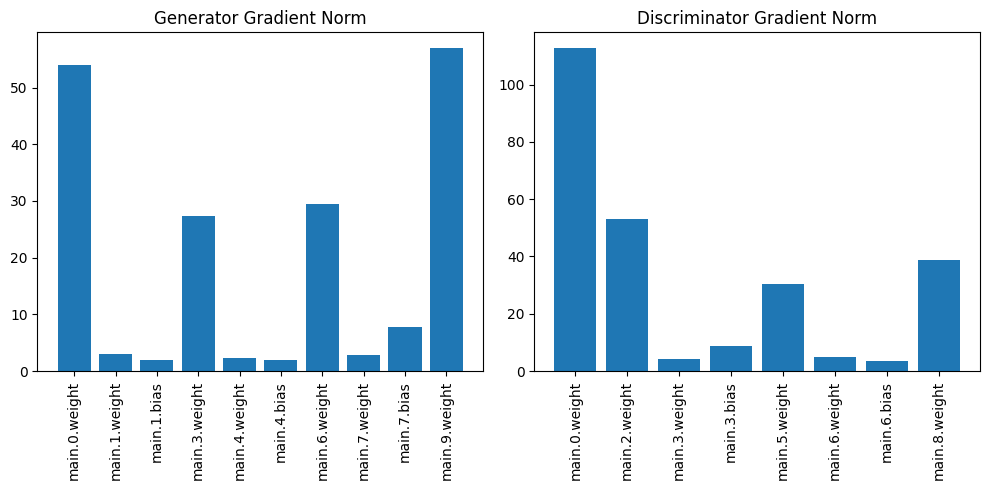

In [7]:
import matplotlib.pyplot as plt
import torch

def plot_gradients(netG, netD):
    # Initialize lists to hold the gradient norms
    #
    g_gradients = {}
    d_gradients = {}

    # Collect gradient norms for each parameter in the generator
    for name, param in netG.named_parameters():
        if param.grad is not None:
            norm = param.grad.data.norm(2).item()  # Convert the norm to a Python float
            print(f"Gradient of netG.{name}: {norm}")
            #record the name and norm
            g_gradients[name] = norm



    # Collect gradient norms for each parameter in the discriminator
    for name, param in netD.named_parameters():
        if param.grad is not None:
            norm = param.grad.data.norm(2).item()  # Convert the norm to a Python float
            print(f"Gradient of netD. {name}: {norm}")
            d_gradients[name] = norm

    # Plotting the gradients
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Generator Gradient Norm")
    #plot the chart
    plt.bar(g_gradients.keys(), g_gradients.values())
    plt.xticks(rotation=90)
    plt.subplot(1, 2, 2)
    plt.title("Discriminator Gradient Norm")
    plt.bar(d_gradients.keys(), d_gradients.values())
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()




# Call the function with the generator and discriminator
plot_gradients(netG, netD)


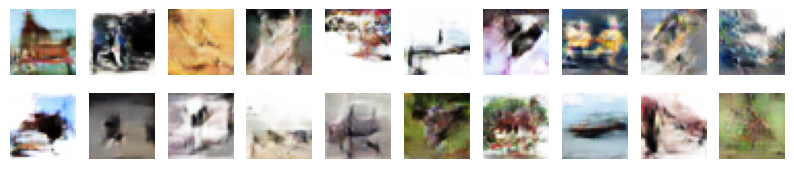

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch



n_classes = 10 # CIFAR-10的类别数
n_examples = 2 # 每个类别生成图片的数量

# 生成条件噪声向量
fixed_noise = torch.randn(n_classes * n_examples, 100, 1, 1, device=device) # noise dimension 100

# 为每个类别生成标
labels = torch.arange(n_classes).repeat(n_examples)

# 生成图片
with torch.no_grad():
    netG.eval()
    # 假设你的生成器接受标签作为条件输入
    # 这里需要根据你的具体实现来调整
    fake_images = netG(fixed_noise).detach().cpu()

import matplotlib.pyplot as plt
import numpy as np

# 假定 fake_images, n_classes, n_examples 已经定义

fig = plt.figure(figsize=(10, 2 ))
for i in range(n_classes * n_examples):
    img = fake_images[i] / 2 + 0.5 # 反归一化
    npimg = img.numpy()
    # 交换行列参数以横向展示图像， 每行10张图片，一共两行
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

#show 20 pictures
plt.show()




In [30]:
#plot the Losses vs epochs
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import numpy as np

def inception_score(images, cuda=True, batch_size=32, resize=False, splits=10):
    """计算 Inception Score.
    参数:
    - images: PyTorch tensor, 大小 [N, 3, H, W]
    - cuda: 是否使用 GPU
    - batch_size: 处理图片的批次大小
    - resize: 是否调整图片为 (299, 299)
    - splits: 计算分数时数据集分割的数量
    """
    N = len(images)
    assert batch_size > 0
    assert N > batch_size

    # 加载 Inception 模型
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # 计算预测和边缘分布
    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size]
        if cuda:
            batch = batch.cuda()
        batch_pred = get_pred(batch)
        preds[i:i + batch_size] = batch_pred

    # 分割数据，计算 Inception Score
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.expand_dims(np.mean(part, axis=0), 0)
        kl_div = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        split_scores.append(np.exp(kl_div))

    return np.mean(split_scores), np.std(split_scores)

# 用法示例
# 假设 `generated_images` 是你的生成图片数据, 形状 [N, 3, H, W]
# is_mean, is_std = inception_score(generated_images, cuda=True, resize=True, batch_size=32)



In [33]:
is_mean, is_std = inception_score(fake_images, cuda=True, resize=True, batch_size=2)
print("Inception Score:", is_mean)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 76.9MB/s]


Inception Score: 1.4027152790938862
